In [1]:
library(tidyverse)
library(readxl)
library(magrittr)
library(lubridate)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.2     v dplyr   0.7.4
v tidyr   0.8.0     v stringr 1.3.0
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date



In [2]:
#import cpi data
cpi_raw <- read_csv("cpi_raw_data.csv")
glimpse(cpi_raw)
#rename the index number column
colnames(cpi_raw)[6] = "Index_number"#

Parsed with column specification:
cols(
  Level = col_character(),
  `Series ref: CPIQ` = col_character(),
  Description = col_character(),
  Quarter = col_character(),
  Weight = col_double(),
  `Index number` = col_double()
)


Observations: 8,198
Variables: 6
$ Level              <chr> "All groups", "Group", "Group", "Group", "Group"...
$ `Series ref: CPIQ` <chr> "SE9A", "SE901", "SE902", "SE903", "SE904", "SE9...
$ Description        <chr> "All groups CPI", "Food", "Alcoholic beverages a...
$ Quarter            <chr> "2006Q2", "2006Q2", "2006Q2", "2006Q2", "2006Q2"...
$ Weight             <dbl> 100.00, 17.39, 7.20, 4.75, 20.02, 5.49, 5.23, 17...
$ `Index number`     <dbl> 815.6607, 759.8784, 628.5355, 1002.0040, 694.444...


In [3]:
# The CPI data has an entire breakdown of the CPI for all quarters
#We only want the rows that are tagged with "all groups" so need to filter those rows
#and select the columns with quarter and index values

cpi_raw %<>%
        select(Level,Quarter,Index_number) %>%
        filter(Level == "All groups") %>%
        select(-Level)
tail(cpi_raw)

Quarter,Index_number
2017Q2,1000.000
2017Q3,1004.894
2017Q4,1006.000
2018Q1,1011.000
2018Q2,1015.000
2018Q3,1024.000


In [4]:
#import fuel price data
fuel_price_raw <- read_csv("fuel_price_raw.csv")

Parsed with column specification:
cols(
  .default = col_double(),
  Week_ending_Friday = col_character(),
  Week_number = col_character(),
  Status = col_character()
)
See spec(...) for full column specifications.


In [5]:
tail(fuel_price_raw)

Week_ending_Friday,Week_number,Status,Dubai_crude_USD.p.bbl,NZ_US_exrate,Dubai_crude_NZD.p.bbl,Diesel_importer_cost_NZc.p.l,Diesel_ETS_NZc.p.l,Diesel_GST_NZc.p.l,Diesel_taxes_NZc.p.l,...,Petrol_importer_cost_NZc.p.l,Petrol_ETS_NZc.p.l,Petrol_GST_NZc.p.l,Petrol_taxes_NZc.p.l,Petrol_price_excl_taxes_NZc.p.l,Petrol_main_port_price_NZc.p.l,Petrol_discounted_retail_price_NZc.p.l,Petrol_importer_margin_NZc.p.l,Petrol_margin_trend_NZc.p.l,Diesel_main_port_price_excl_taxes_NZc.p.l
31/08/2018,2018w35,Provisional,75.44,0.66816,112.9071,91.21200,5.34,20.42703,21.05703,...,87.65434,4.62,28.48584,94.96984,118.8016,232.9000,218.3914,31.14723,29.69536,144.6263
7/09/2018,2018w36,Provisional,75.42,0.65854,114.5261,93.95743,5.34,20.72517,21.35517,...,90.05543,4.62,28.70944,95.19344,120.2923,234.6143,220.1057,30.23682,29.71737,146.6139
14/09/2018,2018w37,Provisional,76.45,0.65374,116.9425,94.38145,5.34,21.06057,21.69057,...,91.28716,4.62,29.15664,95.64064,123.2736,238.0429,223.5343,31.98646,29.73938,148.8499
21/09/2018,2018w38,Provisional,76.76,0.66056,116.2044,93.59333,5.34,21.17237,21.80237,...,91.13291,4.62,29.26844,95.75244,124.0190,238.9000,224.3914,32.88605,29.76139,149.5952
28/09/2018,2018w39,Provisional,79.90,0.66514,120.1251,96.11001,5.34,21.43324,22.06324,...,92.28721,4.62,29.52931,96.01331,125.7581,240.9000,226.3914,33.47089,29.78342,151.3343
5/10/2018,2018w40,Provisional,83.14,0.65568,126.7997,101.23679,5.34,21.42840,22.05840,...,95.72762,4.62,30.22344,100.20744,126.8856,246.6143,231.7131,31.15799,29.80545,152.8250


In [6]:
#import fuel price data
fuel_price_raw <- read_csv("fuel_price_raw.csv")

#Select only the date and petrol price
fuel_price_raw %<>%
    select(Week_ending_Friday, Petrol_discounted_retail_price_NZc.p.l, Dubai_crude_USD.p.bbl )

#The inflation data is reported by quarter so turn the date stamps
# into quarterly labels that match the quarter labels in the index data
colnames(fuel_price_raw)[2] = "Petrol_price_cpl"#
colnames(fuel_price_raw)[3] = "Oil_price_bbl"
fuel_price_raw %<>%
    mutate(Week = dmy(Week_ending_Friday)) %>%
    mutate(Quarter = paste0(year(Week),"Q",quarter(Week)))

#Only want the price and the quarter for the price
#since we are joining with the inflation data
fuel_price <- fuel_price_raw %>%
        select(Quarter,Petrol_price_cpl, Oil_price_bbl)

head(fuel_price)

Parsed with column specification:
cols(
  .default = col_double(),
  Week_ending_Friday = col_character(),
  Week_number = col_character(),
  Status = col_character()
)
See spec(...) for full column specifications.


Quarter,Petrol_price_cpl,Oil_price_bbl
2004Q2,114.5,32.10
2004Q2,113.0,32.65
2004Q2,117.3,33.38
2004Q2,121.9,34.41
2004Q2,121.3,35.77
2004Q2,123.9,35.03


In [7]:
#Join the price and cpi data (by Quarter)
#only joins the tables where we have both the cpi and price
#data for that quarter
fuel_inflation <- inner_join(fuel_price,cpi_raw, by = "Quarter")

fuel_inflation %>% head()

Quarter,Petrol_price_cpl,Oil_price_bbl,Index_number
2006Q2,156.2,61.13,815.6607
2006Q2,159.3,62.65,815.6607
2006Q2,164.5,65.75,815.6607
2006Q2,168.8,66.49,815.6607
2006Q2,170.9,66.81,815.6607
2006Q2,170.9,65.78,815.6607


In [8]:
#There are approximately 12 weeks in every quarter
#so take the average of these prices for each quarter to smooth the data
#We couldn't get group_by to work for some reason so 
#used aggregate
avg_fuel_inflation <- aggregate(fuel_inflation[, 2:4], list(fuel_inflation$Quarter), mean)
colnames(avg_fuel_inflation)[1] = "Quarter"
head(avg_fuel_inflation)

Quarter,Petrol_price_cpl,Oil_price_bbl,Index_number
2006Q2,167.7846,64.77308,815.6607
2006Q3,166.0615,65.87077,821.3703
2006Q4,140.9231,57.23462,819.7390
2007Q1,142.3077,55.47154,823.8173
2007Q2,153.8231,64.67154,831.9739
2007Q3,156.6000,70.02538,836.0522


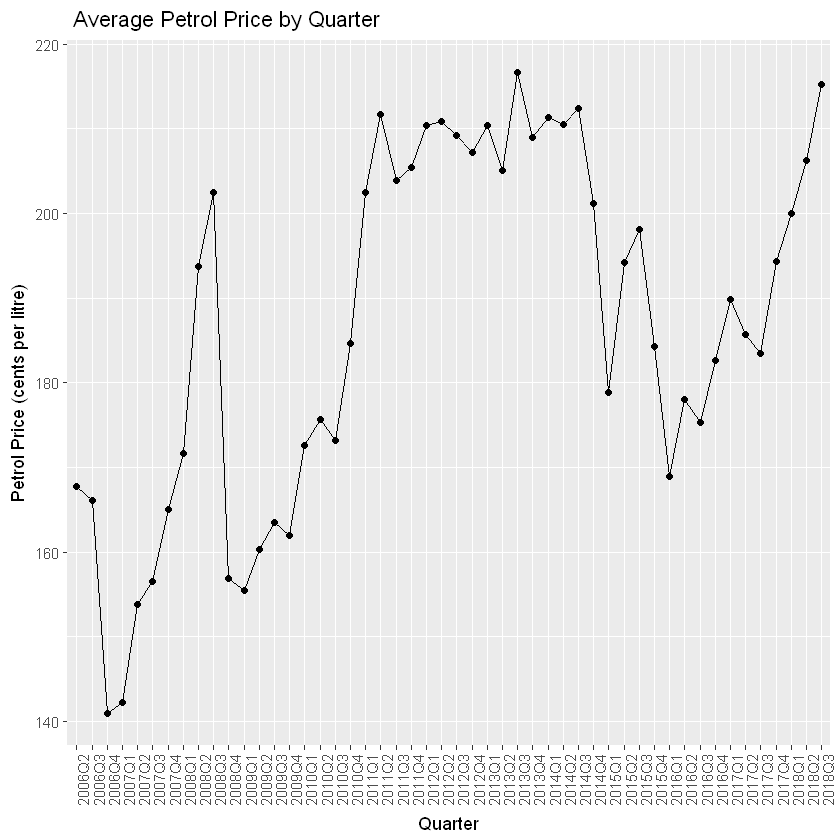

In [11]:
#Plot fuel price over time
#Note since the quarterly figures are averaged from weekly data and 
#we don't have the inflation figures for quarter 4 yet so this graph doesn't
#include the new fuel taxes from the 1st October 2018
avg_fuel_inflation %>%
    ggplot( aes(x = Quarter, y = Petrol_price_cpl, group = 1) )+geom_line() + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    ggtitle(" Average Petrol Price by Quarter")+
    
xlab("Quarter")+ylab ("Petrol Price (cents per litre)")

[1] 815.6607

Quarter,Petrol_price_cpl,Oil_price_bbl,Index_number,Inflation_adjusted_price,Inflation_adjusted_barrel
2006Q2,167.7846,64.77308,815.6607,167.7846,64.77308
2006Q3,166.0615,65.87077,821.3703,164.9072,65.41288
2006Q4,140.9231,57.23462,819.7390,140.2220,56.94987
2007Q1,142.3077,55.47154,823.8173,140.8987,54.92232
2007Q2,153.8231,64.67154,831.9739,150.8069,63.40347
2007Q3,156.6000,70.02538,836.0522,152.7805,68.31745


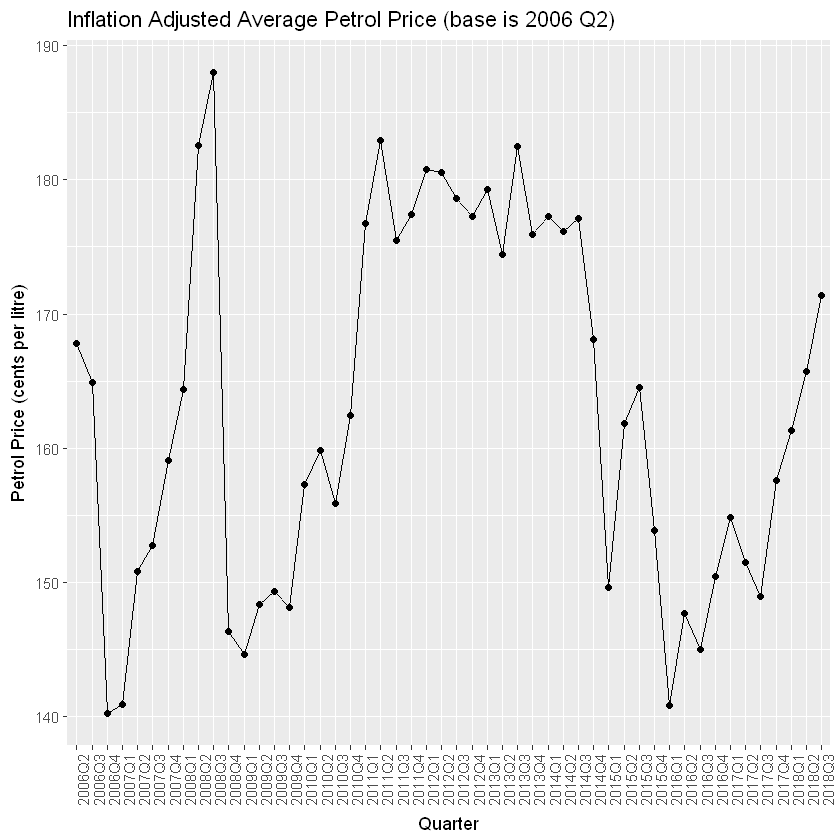

In [17]:
#Want to adjust the fuel price for inflation
#so take the base level from 2006 Q2 - the first quarter in the table

base_index = avg_fuel_inflation[[4]][1]
base_index
#add a column to the table for inflation adjusted price
avg_fuel_inflation %<>% mutate(Inflation_adjusted_price = Petrol_price_cpl * base_index/ Index_number)
avg_fuel_inflation %<>% mutate(Inflation_adjusted_barrel = Oil_price_bbl * base_index/ Index_number)
avg_fuel_inflation %>% head()

#Plot the inflation adjusted price data
avg_fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_price, group = 1) )+geom_point() + geom_line() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Average Petrol Price (base is 2006 Q2)")+
        xlab("Quarter")+ylab("Petrol Price (cents per litre)")

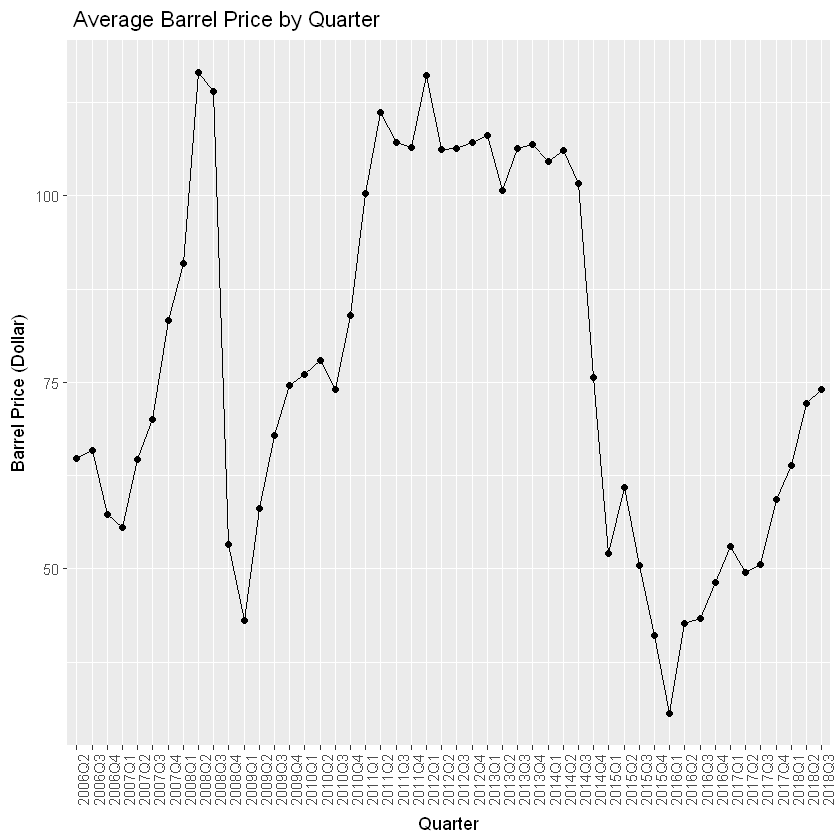

In [18]:
avg_fuel_inflation %>%
    ggplot( aes(x = Quarter, y = Oil_price_bbl, group = 1) )+geom_line() + geom_point() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    ggtitle(" Average Barrel Price by Quarter")+
    
xlab("Quarter")+ylab ("Barrel Price (Dollar)")

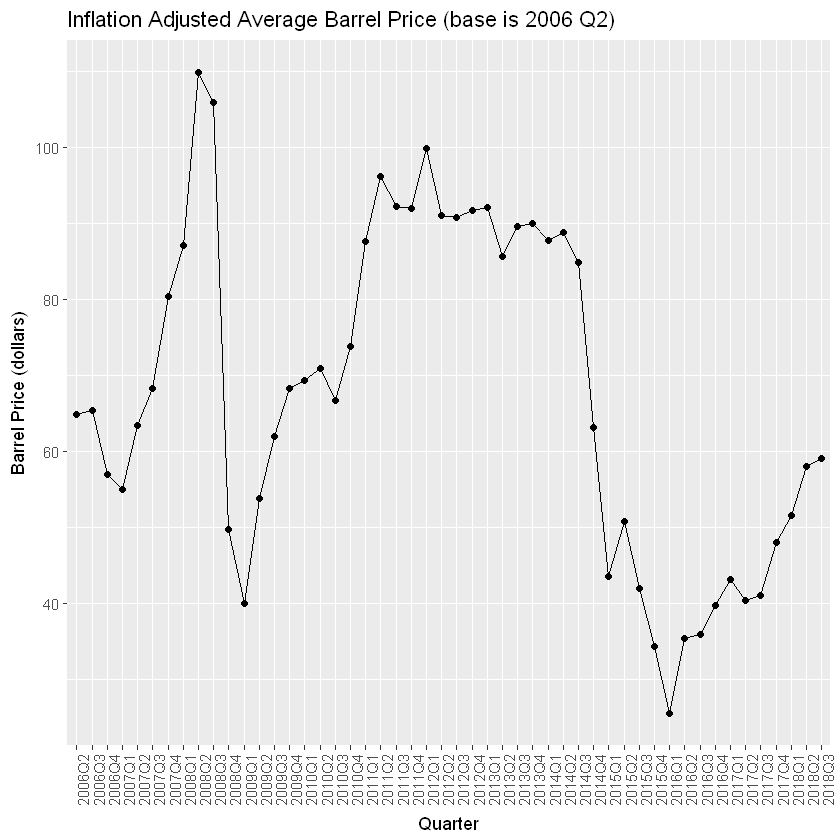

In [20]:
#Plot the inflation adjusted price data
avg_fuel_inflation%>%
      ggplot( aes(x = Quarter, y = Inflation_adjusted_barrel, group = 1) )+geom_point() + geom_line() + theme(axis.text.x = element_text(angle = 90, hjust = 1))+
        ggtitle("Inflation Adjusted Average Barrel Price (base is 2006 Q2)")+
        xlab("Quarter")+ylab("Barrel Price (dollars)")

In [21]:
head(avg_fuel_inflation)

Quarter,Petrol_price_cpl,Oil_price_bbl,Index_number,Inflation_adjusted_price,Inflation_adjusted_barrel
2006Q2,167.7846,64.77308,815.6607,167.7846,64.77308
2006Q3,166.0615,65.87077,821.3703,164.9072,65.41288
2006Q4,140.9231,57.23462,819.7390,140.2220,56.94987
2007Q1,142.3077,55.47154,823.8173,140.8987,54.92232
2007Q2,153.8231,64.67154,831.9739,150.8069,63.40347
2007Q3,156.6000,70.02538,836.0522,152.7805,68.31745
